In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import graph_tool.all as gt
import sys
# sys.insert_path('/Users/glover.co/Documents/laszlo/NetDesign/scripts/')
import assembly_tree as at
import mcmc
import treelib
from itertools import product

In [2]:
X = np.vstack([np.eye(3) for i in range(2)])
O = np.array([[0,1,1],[1,0,1],[1,1,2]])
capacity = O.sum(axis=1,dtype=int)
target = nx.Graph()
target.add_nodes_from(np.arange(6))
target.add_edges_from([[0,1],[1,2],[2,0],[3,4],[4,5],[5,3],[2,5]])
                    #    [6,7],[7,8],[8,6],[9,10],[10,11],[11,9],[2,5]])
                    #    [12,13],[13,14],[14,12],[15,16],[16,17],[17,15],
                    #    [2,5],[5,8],[8,11],[11,14],[14,17],[17,2]])

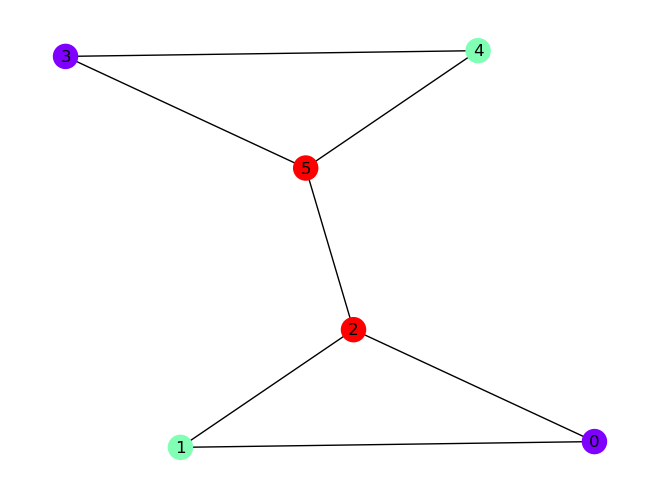

In [3]:
at.draw_network(target,X,with_labels=True)

In [4]:

ex0 = mcmc.AssemblyTree(target, X, O, capacity)


In [52]:
ex0.update_tree(dist=[0,0,0,1])
ex0.Tree.show()


0
├── 1
│   ├── 3
│   │   ├── 5
│   │   └── 6
│   └── 4
└── 2



Text(0.5, 1.0, '[np.float64(0.66)]')

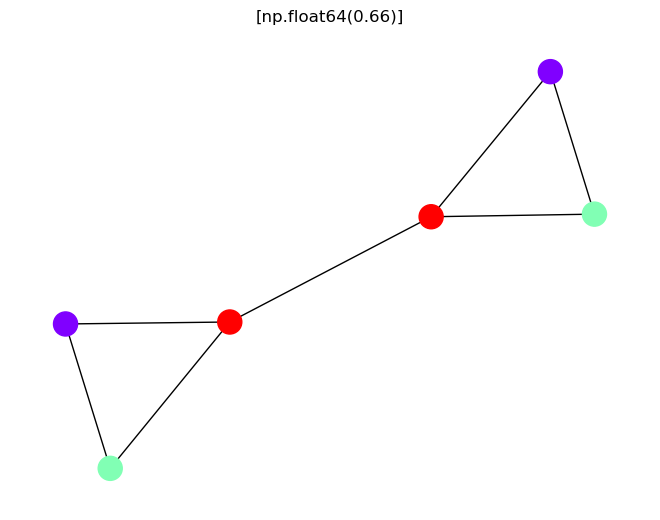

In [61]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],ex0.X)
plt.title(ex0.Tree.get_node(0).data.p)

In [21]:
test = nx.compose(ex0.Tree.get_node(1).data.subgraph[0], ex0.Tree.get_node(2).data.subgraph[0])
test = nx.compose(test,ex0.Tree.get_node(3).data.subgraph[0])
test = nx.compose(test,ex0.Tree.get_node(4).data.subgraph[0])

In [10]:
A = nx.adjacency_matrix(test, nodelist=test.nodes(), weight='weight').todense()
(X[test.nodes()]@O - A@X[test.nodes()])@X[test.nodes()].T, test.nodes()

(array([[0., 0., 0., 1., 0., 1.],
        [0., 2., 2., 1., 0., 1.],
        [1., 2., 2., 0., 1., 0.],
        [1., 0., 0., 0., 1., 0.],
        [0., 1., 1., 1., 0., 1.],
        [1., 1., 1., 0., 1., 0.]]),
 NodeView((np.int64(0), np.int64(2), np.int64(5), np.int64(1), np.int64(3), np.int64(4))))

In [22]:
new_g = at.microcanonical_ensemble(X,O,capacity,initial_graph=test.copy())

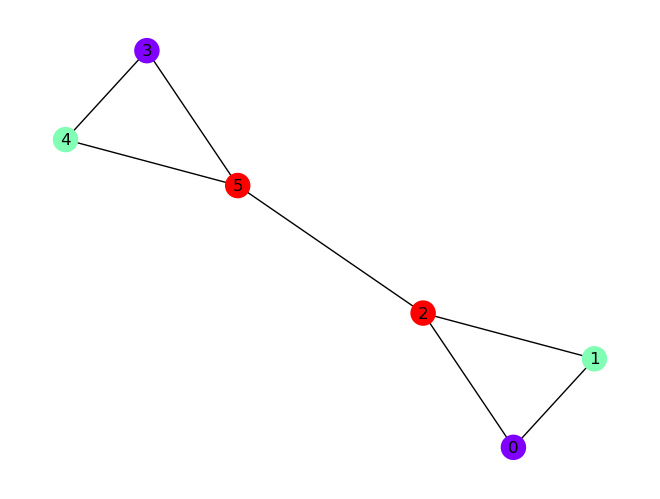

In [23]:
at.draw_network(new_g,X,with_labels=True)

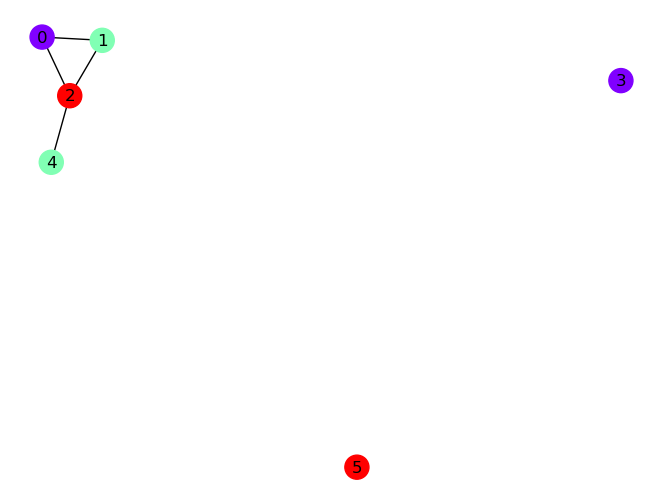

In [55]:
at.draw_network(test,X, with_labels=True)

In [71]:
A = nx.adjacency_matrix(test).todense()

X[list(test.nodes())]@O - A@X[list(test.nodes())]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 2.],
       [1., 0., 1.]])

In [67]:
ex0.Tree.show()

0
├── 1
│   ├── 3
│   ├── 4
│   └── 5
└── 2



Text(0.5, 1.0, '[np.float64(1.0)]')

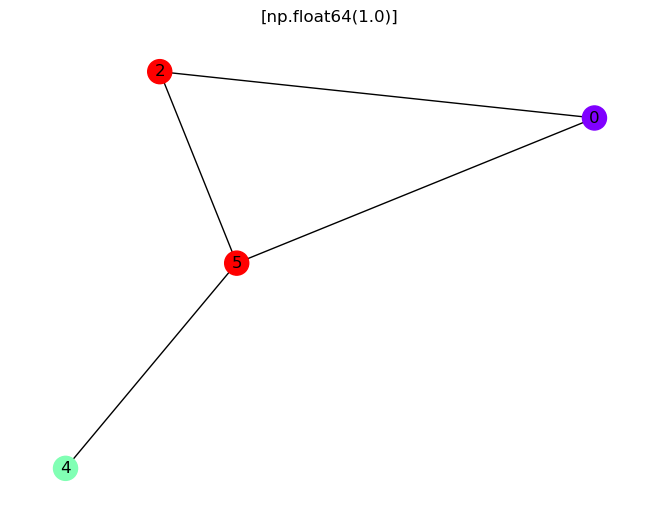

In [77]:
at.draw_network(ex0.Tree.get_node(1).data.subgraph[0],ex0.X,with_labels=True)
plt.title(ex0.Tree.get_node(1).data.p)

In [ ]:
at.draw_network(ex0.Tree.get_node(3).data.subgraph[0],ex0.X)

In [24]:
ex0.update_prob(0)

In [ ]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[2],ex0.X)

In [ ]:
initial_graph = nx.Graph()
initial_graph.add_nodes_from([0,1,2,5])
initial_graph.add_edges_from([[0,1],[2,5]])
p, samples, idx = at.prob_dist(ex0.X,ex0.O,ex0.capacity,initial_graph=initial_graph,max_edges=True,labeled=False)
at.draw_network(samples[1],ex0.X,with_labels=True)

In [ ]:
p

In [ ]:
at.draw_network(ex0.Tree.get_node(0).data.subgraph[0],ex0.X,with_labels=True)

In [ ]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[1],ex0.X)

In [ ]:
at.draw_network(ex0.Tree.get_node(2).data.subgraph[0],ex0.X)

In [ ]:
sum(ex0.Tree.get_node(0).data.p)

In [ ]:
sub_nodes

In [ ]:
g = nx.Graph()
g.add_nodes_from(np.arange(6))
p, samples, idx = at.prob_dist(X,O,capacity,initial_graph=g,max_edges=True,labeled=False,max_iters=100)

In [ ]:
true_A = ex0.target_A[:,sub_nodes][sub_nodes,:]
cur_a = nx.adjacency_matrix(samples[0]).todense()
np.allclose(true_A,cur_a)

In [ ]:
at.draw_network(samples[3],X,with_labels=True)

In [ ]:
p

In [ ]:
children = ex0.Tree.get_node(0).successors(ex0.Tree.identifier)

In [56]:
zero_prob = np.prod(np.array([np.prod(x) for c in children for x in ex0.Tree.get_node(c).data.logP ]))

In [63]:
subgraph_list = [ex0.Tree.get_node(c).data.subgraph for c in children]

In [ ]:
subgraph_list

In [9]:
x = 1
y = 2
z = 3
true_list = [x,y,z]
for j, s in enumerate(true_list):
    true_list[j] = 4

In [70]:
list1 = [1,2,3,4,5,6]
list2 = [4,5,6,7]
list3 = [2,1]

In [71]:
from itertools import product

In [ ]:
np.prod(list(product(list1, list2, list3)),axis=1)

In [ ]:
bowtie = nx.Graph()
bowtie.add_nodes_from(np.arange(6))
# bowtie.add_edges_from([[0,1],[1,2],[2,0],[3,4],[4,5],[5,3],[2,5]])
bowtie.add_edges_from([[0,1],[4,2],[2,5],[5,1],[3,4],[5,3],[2,0]])
at.draw_network(bowtie,X,with_labels=True)

In [64]:
subgraph = nx.Graph()
subgraph.add_nodes_from([0,1,2,3])
subgraph.add_edges_from([[0,1],[1,2],[2,3],[3,0]])

In [66]:
iso = nx.isomorphism.GraphMatcher(bowtie, subgraph)

In [ ]:
iso.subgraph_is_isomorphic()